### Import Libraries

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.distributions as dist
from torchsummary import summary
import math
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import re
from skimage.metrics  import structural_similarity as ssim

from importlib import reload
import visualization

# locals
import model_architectures_2d

reload(model_architectures_2d)
from model_architectures_2d import DataSeg2Seg, UNet, MiniUNet, MinierUNet

reload(visualization)
from visualization import brain_diff, viz_slices

### Define Paths

In [2]:
research_dir = r"D:/school/research"
code_dir = os.path.join(research_dir, "code")
model_dir = os.path.join(code_dir, "explore_again", "models")
data_dir = os.path.join(research_dir, "data")
dhcp_rel2 = os.path.join(data_dir, "dhcp_rel2")
processed_dir = os.path.join(dhcp_rel2, "processed")
volume_dir = os.path.join(processed_dir, "volumes")
seg_dir = os.path.join(processed_dir, "segments")
seg_vol_dir = os.path.join(processed_dir, "volume_segments")
pred_dir = os.path.join(dhcp_rel2, "predictions")
seg_pred_dir = os.path.join(pred_dir, "vae_9seg")

l1_dir = os.path.join(volume_dir, "l1")
l5_dir = os.path.join(volume_dir, "l5")

l1_seg_dir = os.path.join(seg_dir, "l1")
l5_seg_dir = os.path.join(seg_dir, "l5")

l1_seg_vol_dir = os.path.join(seg_vol_dir, "l1")
l5_seg_vol_dir = os.path.join(seg_vol_dir, "l5")

l1_seg_pred_dir = os.path.join(seg_pred_dir, "l1")
l5_seg_pred_dir = os.path.join(seg_pred_dir, "l5")

### Load Data

In [3]:
np.random.seed(42)
num_samples = int(len(os.listdir(l1_dir)) / 2)
samples = np.array([i for i in range(0, num_samples)])
np.random.shuffle(samples)

split_val = int(0.8 * num_samples)
train_indices = samples[0:split_val]
val_indices = samples[split_val:]

num_test = int(len(os.listdir(l5_dir)) / 2)
test_indices = np.array([i for i in range(0, num_test)])

In [4]:
bsize = 64
train = DataSeg2Seg(l1_seg_vol_dir, l1_seg_pred_dir, train_indices, seg_num=2, batch_size=bsize)
val = DataSeg2Seg(l1_seg_vol_dir, l1_seg_pred_dir, val_indices, seg_num=2, batch_size=bsize)
test = DataSeg2Seg(l5_seg_vol_dir, l5_seg_pred_dir, test_indices, seg_num=2, batch_size=bsize)

# batch_size = 1
# train_loader = DataLoader(train, batch_size=batch_size)#, num_workers=1)
# val_loader = DataLoader(val, batch_size=batch_size)#, num_workers=1)

### Try Mini UNet

In [7]:
model = MiniUNet(1)

# model = nn.DataParallel(model)
model.cuda()
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-07)

num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(train, unit="batch", ascii=' >=') as tepoch:
        model.train()
        data_counter = 0
        for data in tepoch:
            for x, y in data:
                optimizer.zero_grad()
                
                x = torch.Tensor(x).cuda()
                y = torch.Tensor(y).cuda()
                
                output = model(x)
                loss = criterion(y, output)
                
                # backward
                loss.backward()
                optimizer.step()

                total_loss += loss.data
                data_counter += 1

        total_loss /= (data_counter)
            
        tepoch.set_postfix(loss=loss.item())
        val_loss = 0
        model.eval()
        data_counter = 0
        for data in val:
            with torch.no_grad():
                for x, y in data:
                    x = torch.Tensor(x).cuda()
                    y = torch.Tensor(y).cuda()

                    output = model(x)
                    loss = criterion(y, output)

                    val_loss += loss.data
                    data_counter += 1
        
        val_loss /= (data_counter)
        
        print('epoch [{}/{}], train_loss:{:.4f}, val_loss:{:.4f}'
              .format(epoch+1, num_epochs, total_loss, val_loss))

100%|=============================================================================| 166/166 [06:23<00:00,  2.31s/batch]


epoch [1/100], train_loss:0.0000, val_loss:0.0000


 11%|========                                                                      | 18/166 [00:42<05:50,  2.37s/batch]


KeyboardInterrupt: 

Text(0.5, 1.0, 'OG - Refined Seg Pred')

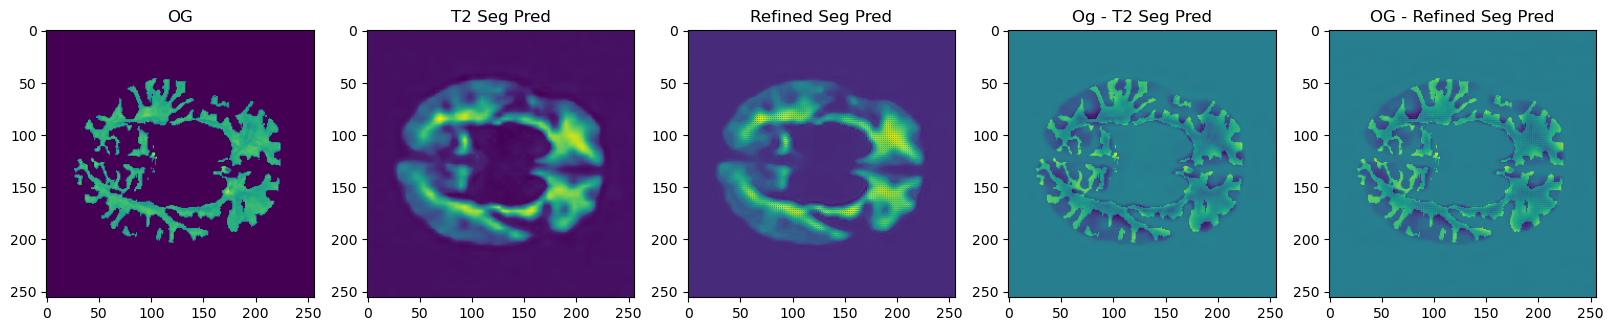

In [19]:
x,y = train[0][1]
x = torch.Tensor(x).cuda()
y = torch.Tensor(y).cuda()
output = model(x)

og = np.reshape(y.detach().cpu().numpy()[-1], (256, 256))
og_pred = np.reshape(x.detach().cpu().numpy()[-1], (256, 256))
pred = np.reshape(output.detach().cpu().numpy()[-1], (256, 256))

fig, ax = plt.subplots(1, 5, figsize=(20,20))

ax[0].imshow(og)
ax[0].set_title("OG")

ax[1].imshow(og_pred)
ax[1].set_title("T2 Seg Pred")

ax[2].imshow(pred)
ax[2].set_title("Refined Seg Pred")

ax[3].imshow(og - og_pred)
ax[3].set_title("Og - T2 Seg Pred")

ax[4].imshow(og - pred)
ax[4].set_title("OG - Refined Seg Pred")

In [34]:
train_sample = []
for i in range(0,10):
    train_sample.extend(train[i])

In [44]:
### This initializes a minier unet with the ground truth in and out
model = MinierUNet(1)

model.cuda()
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-07)

num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(train_sample, unit="batch", ascii=' >=') as tepoch:
        model.train()
        data_counter = 0
        for data in tepoch:
            optimizer.zero_grad()
            _, y = data
            
            y = torch.Tensor(y).cuda()
            
            output = model(y)
            loss = criterion(y, output)

            # backward
            loss.backward()
            optimizer.step()

            total_loss += loss.data
            data_counter += 1

        total_loss /= (data_counter)
        
        print('epoch [{}/{}], train_loss:{:.4f}'
              .format(epoch+1, num_epochs, total_loss))

100%|===============================================================================| 40/40 [00:12<00:00,  3.17batch/s]


epoch [1/100], train_loss:0.0296


100%|===============================================================================| 40/40 [00:12<00:00,  3.17batch/s]


epoch [2/100], train_loss:0.0020


100%|===============================================================================| 40/40 [00:12<00:00,  3.17batch/s]


epoch [3/100], train_loss:0.0010


100%|===============================================================================| 40/40 [00:12<00:00,  3.17batch/s]


epoch [4/100], train_loss:0.0008


100%|===============================================================================| 40/40 [00:12<00:00,  3.16batch/s]


epoch [5/100], train_loss:0.0006


100%|===============================================================================| 40/40 [00:12<00:00,  3.16batch/s]


epoch [6/100], train_loss:0.0006


100%|===============================================================================| 40/40 [00:12<00:00,  3.16batch/s]


epoch [7/100], train_loss:0.0005


100%|===============================================================================| 40/40 [00:12<00:00,  3.17batch/s]


epoch [8/100], train_loss:0.0005


100%|===============================================================================| 40/40 [00:12<00:00,  3.11batch/s]


epoch [9/100], train_loss:0.0004


100%|===============================================================================| 40/40 [00:13<00:00,  3.07batch/s]


epoch [10/100], train_loss:0.0004


100%|===============================================================================| 40/40 [00:12<00:00,  3.12batch/s]


epoch [11/100], train_loss:0.0004


100%|===============================================================================| 40/40 [00:12<00:00,  3.12batch/s]


epoch [12/100], train_loss:0.0004


100%|===============================================================================| 40/40 [00:12<00:00,  3.11batch/s]


epoch [13/100], train_loss:0.0004


100%|===============================================================================| 40/40 [00:12<00:00,  3.11batch/s]


epoch [14/100], train_loss:0.0003


100%|===============================================================================| 40/40 [00:12<00:00,  3.12batch/s]


epoch [15/100], train_loss:0.0003


100%|===============================================================================| 40/40 [00:12<00:00,  3.12batch/s]


epoch [16/100], train_loss:0.0003


100%|===============================================================================| 40/40 [00:12<00:00,  3.12batch/s]


epoch [17/100], train_loss:0.0003


100%|===============================================================================| 40/40 [00:12<00:00,  3.12batch/s]


epoch [18/100], train_loss:0.0003


100%|===============================================================================| 40/40 [00:12<00:00,  3.12batch/s]


epoch [19/100], train_loss:0.0003


100%|===============================================================================| 40/40 [00:12<00:00,  3.12batch/s]


epoch [20/100], train_loss:0.0003


 15%|============                                                                    | 6/40 [00:01<00:11,  3.02batch/s]


KeyboardInterrupt: 

Text(0.5, 1.0, 'OG - Refined Seg Pred')

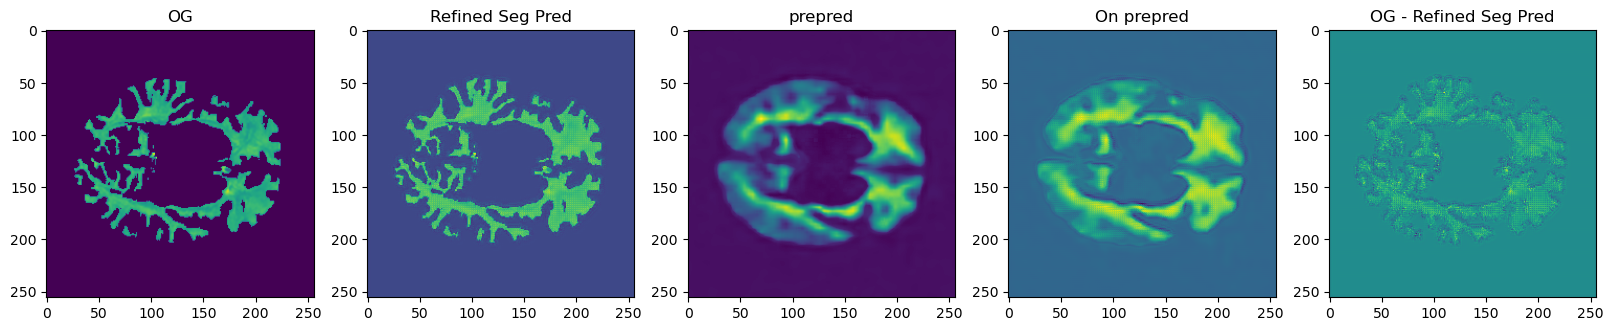

In [59]:
x, y = train_sample[1]
x = torch.Tensor(x).cuda()
y = torch.Tensor(y).cuda()
output = model(y)
x_output = model(x)

og = np.reshape(y.detach().cpu().numpy()[-1], (256, 256))
pred = np.reshape(output.detach().cpu().numpy()[-1], (256, 256))
xpred = np.reshape(x_output.detach().cpu().numpy()[-1], (256, 256))
ogx = np.reshape(x.detach().cpu().numpy()[-1], (256, 256))

fig, ax = plt.subplots(1, 5, figsize=(20,20))

ax[0].imshow(og)
ax[0].set_title("OG")

ax[1].imshow(pred)
ax[1].set_title("Refined Seg Pred")

ax[2].imshow(ogx)
ax[2].set_title("prepred")

ax[3].imshow(xpred)
ax[3].set_title("On prepred")

ax[4].imshow(og - pred)
ax[4].set_title("OG - Refined Seg Pred")

In [51]:
from copy import deepcopy

In [52]:
minierunet_backup = deepcopy(model)

In [63]:
### Then we fine tune on the predicted results
criterion = nn.MSELoss()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-07)

num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(train_sample, unit="batch", ascii=' >=') as tepoch:
        model.train()
        data_counter = 0
        for data in tepoch:
            optimizer.zero_grad()
            x, y = data
            
            x = torch.Tensor(x).cuda()
            y = torch.Tensor(y).cuda()
            
            output = model(x)
            loss = criterion(y, output)

            # backward
            loss.backward()
            optimizer.step()

            total_loss += loss.data
            data_counter += 1

        total_loss /= (data_counter)
        
        print('epoch [{}/{}], train_loss:{:.4f}'
              .format(epoch+1, num_epochs, total_loss))

100%|===============================================================================| 40/40 [00:17<00:00,  2.31batch/s]


epoch [1/100], train_loss:0.0034


100%|===============================================================================| 40/40 [00:17<00:00,  2.23batch/s]


epoch [2/100], train_loss:0.0033


100%|===============================================================================| 40/40 [00:17<00:00,  2.26batch/s]


epoch [3/100], train_loss:0.0033


100%|===============================================================================| 40/40 [00:17<00:00,  2.31batch/s]


epoch [4/100], train_loss:0.0033


100%|===============================================================================| 40/40 [00:16<00:00,  2.37batch/s]


epoch [5/100], train_loss:0.0033


100%|===============================================================================| 40/40 [00:21<00:00,  1.85batch/s]


epoch [6/100], train_loss:0.0033


100%|===============================================================================| 40/40 [00:17<00:00,  2.32batch/s]


epoch [7/100], train_loss:0.0032


100%|===============================================================================| 40/40 [00:17<00:00,  2.34batch/s]


epoch [8/100], train_loss:0.0032


100%|===============================================================================| 40/40 [00:16<00:00,  2.37batch/s]


epoch [9/100], train_loss:0.0032


100%|===============================================================================| 40/40 [00:20<00:00,  1.97batch/s]


epoch [10/100], train_loss:0.0032


100%|===============================================================================| 40/40 [00:16<00:00,  2.35batch/s]


epoch [11/100], train_loss:0.0032


100%|===============================================================================| 40/40 [00:19<00:00,  2.05batch/s]


epoch [12/100], train_loss:0.0032


100%|===============================================================================| 40/40 [00:20<00:00,  1.95batch/s]


epoch [13/100], train_loss:0.0032


 15%|============                                                                    | 6/40 [00:02<00:15,  2.14batch/s]


KeyboardInterrupt: 

In [65]:
x, y = train_sample[1]
# x = torch.Tensor(x).cuda()
# y = torch.Tensor(y).cuda()
# output = model(x)

# og = np.reshape(y.detach().cpu().numpy()[-1], (256, 256))
# og_pred = np.reshape(x.detach().cpu().numpy()[-1], (256, 256))
# pred = np.reshape(output.detach().cpu().numpy()[-1], (256, 256))

# fig, ax = plt.subplots(1, 5, figsize=(20,20))

# ax[0].imshow(og)
# ax[0].set_title("OG")

# ax[1].imshow(og_pred)
# ax[1].set_title("T2 Seg Pred")

# ax[2].imshow(pred)
# ax[2].set_title("Refined Seg Pred")

# ax[3].imshow(og - og_pred)
# ax[3].set_title("Og - T2 Seg Pred")

# ax[4].imshow(og - pred)
# ax[4].set_title("OG - Refined Seg Pred")

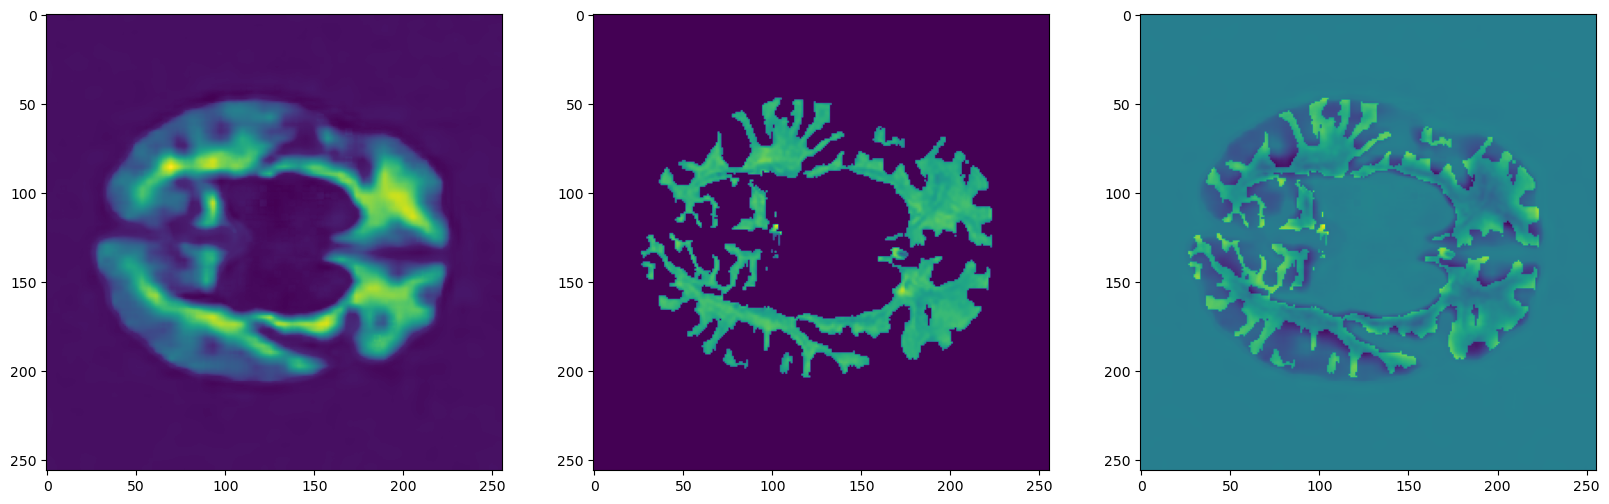

In [71]:
fig, ax = plt.subplots(1,3, figsize=(20,20))

ax[0].imshow(np.reshape((x)[-1], (256, 256)))
ax[1].imshow(np.reshape((y)[-1], (256, 256)))
ax[2].imshow(np.reshape((y-x)[-1], (256, 256)))

Text(0.5, 1.0, 'OG - Refined Seg Pred')

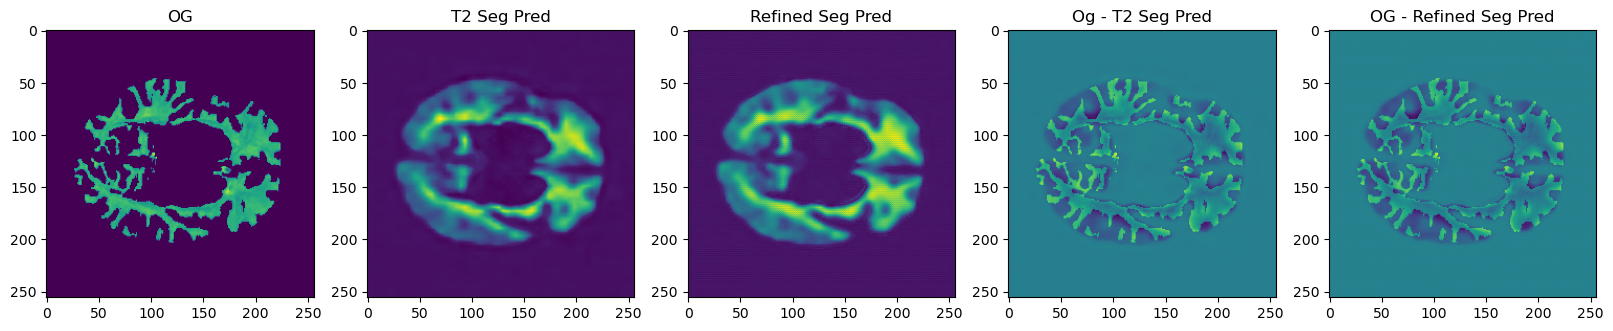

In [42]:
x, y = train_sample[1]
x = torch.Tensor(x).cuda()
y = torch.Tensor(y).cuda()
output = model(x)

og = np.reshape(y.detach().cpu().numpy()[-1], (256, 256))
og_pred = np.reshape(x.detach().cpu().numpy()[-1], (256, 256))
pred = np.reshape(output.detach().cpu().numpy()[-1], (256, 256))

fig, ax = plt.subplots(1, 5, figsize=(20,20))

ax[0].imshow(og)
ax[0].set_title("OG")

ax[1].imshow(og_pred)
ax[1].set_title("T2 Seg Pred")

ax[2].imshow(pred)
ax[2].set_title("Refined Seg Pred")

ax[3].imshow(og - og_pred)
ax[3].set_title("Og - T2 Seg Pred")

ax[4].imshow(og - pred)
ax[4].set_title("OG - Refined Seg Pred")

### Model on residuals

In [72]:
train_sample = []
for i in range(0,10):
    train_sample.extend(train[i])

In [86]:
### This initializes a minier unet with the ground truth in and out
model = MinierUNet(1)

model.cuda()
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-07)

num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(train_sample, unit="batch", ascii=' >=') as tepoch:
        model.train()
        data_counter = 0
        for data in tepoch:
            optimizer.zero_grad()
            x, y = data
            residual = y - x
            
            residual = torch.Tensor(residual).cuda()
            y = torch.Tensor(y).cuda()
            
            output = model(residual)
            loss = criterion(y, output)

            # backward
            loss.backward()
            optimizer.step()

            total_loss += loss.data
            data_counter += 1

        total_loss /= (data_counter)
        
        print('epoch [{}/{}], train_loss:{:.4f}'
              .format(epoch+1, num_epochs, total_loss))

100%|===============================================================================| 40/40 [00:13<00:00,  3.05batch/s]


epoch [1/100], train_loss:0.0190


100%|===============================================================================| 40/40 [00:12<00:00,  3.09batch/s]


epoch [2/100], train_loss:0.0029


100%|===============================================================================| 40/40 [00:12<00:00,  3.08batch/s]


epoch [3/100], train_loss:0.0020


100%|===============================================================================| 40/40 [00:13<00:00,  3.07batch/s]


epoch [4/100], train_loss:0.0016


100%|===============================================================================| 40/40 [00:13<00:00,  3.08batch/s]


epoch [5/100], train_loss:0.0013


100%|===============================================================================| 40/40 [00:13<00:00,  3.03batch/s]


epoch [6/100], train_loss:0.0011


100%|===============================================================================| 40/40 [00:12<00:00,  3.08batch/s]


epoch [7/100], train_loss:0.0009


100%|===============================================================================| 40/40 [00:13<00:00,  3.08batch/s]


epoch [8/100], train_loss:0.0008


100%|===============================================================================| 40/40 [00:13<00:00,  3.07batch/s]


epoch [9/100], train_loss:0.0007


100%|===============================================================================| 40/40 [00:12<00:00,  3.11batch/s]


epoch [10/100], train_loss:0.0007


100%|===============================================================================| 40/40 [00:12<00:00,  3.12batch/s]


epoch [11/100], train_loss:0.0006


100%|===============================================================================| 40/40 [00:12<00:00,  3.11batch/s]


epoch [12/100], train_loss:0.0006


100%|===============================================================================| 40/40 [00:12<00:00,  3.12batch/s]


epoch [13/100], train_loss:0.0006


100%|===============================================================================| 40/40 [00:12<00:00,  3.12batch/s]


epoch [14/100], train_loss:0.0005


100%|===============================================================================| 40/40 [00:12<00:00,  3.10batch/s]


epoch [15/100], train_loss:0.0005


100%|===============================================================================| 40/40 [00:12<00:00,  3.11batch/s]


epoch [16/100], train_loss:0.0005


100%|===============================================================================| 40/40 [00:12<00:00,  3.12batch/s]


epoch [17/100], train_loss:0.0005


100%|===============================================================================| 40/40 [00:13<00:00,  3.04batch/s]


epoch [18/100], train_loss:0.0005


100%|===============================================================================| 40/40 [00:13<00:00,  3.00batch/s]


epoch [19/100], train_loss:0.0005


 72%|=========================================================                      | 29/40 [00:10<00:03,  2.85batch/s]


KeyboardInterrupt: 

# EXPLORE THIS ONE FURTHER, MODELING RESIDUAL BACK TO SEGMENTED

Text(0.5, 1.0, 'New residual')

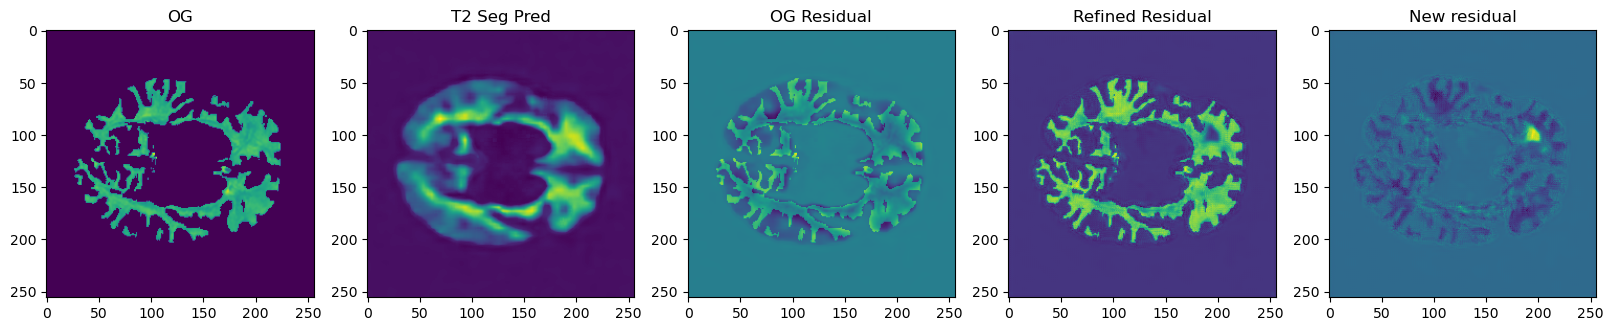

In [90]:
x, y = train_sample[1]
residual = y - x
residual = torch.Tensor(residual).cuda()
output = model(residual)

og = np.reshape(y[-1], (256, 256))
og_pred = np.reshape(x[-1], (256, 256))
og_residual = np.reshape(residual.detach().cpu().numpy()[-1], (256, 256))
pred = np.reshape(output.detach().cpu().numpy()[-1], (256, 256))

fig, ax = plt.subplots(1, 5, figsize=(20,20))

ax[0].imshow(og)
ax[0].set_title("OG")

ax[1].imshow(og_pred)
ax[1].set_title("T2 Seg Pred")

ax[2].imshow(og_residual)
ax[2].set_title("OG Residual")

ax[3].imshow(pred)
ax[3].set_title("Refined Residual")

ax[4].imshow(og - pred)
ax[4].set_title("New residual")

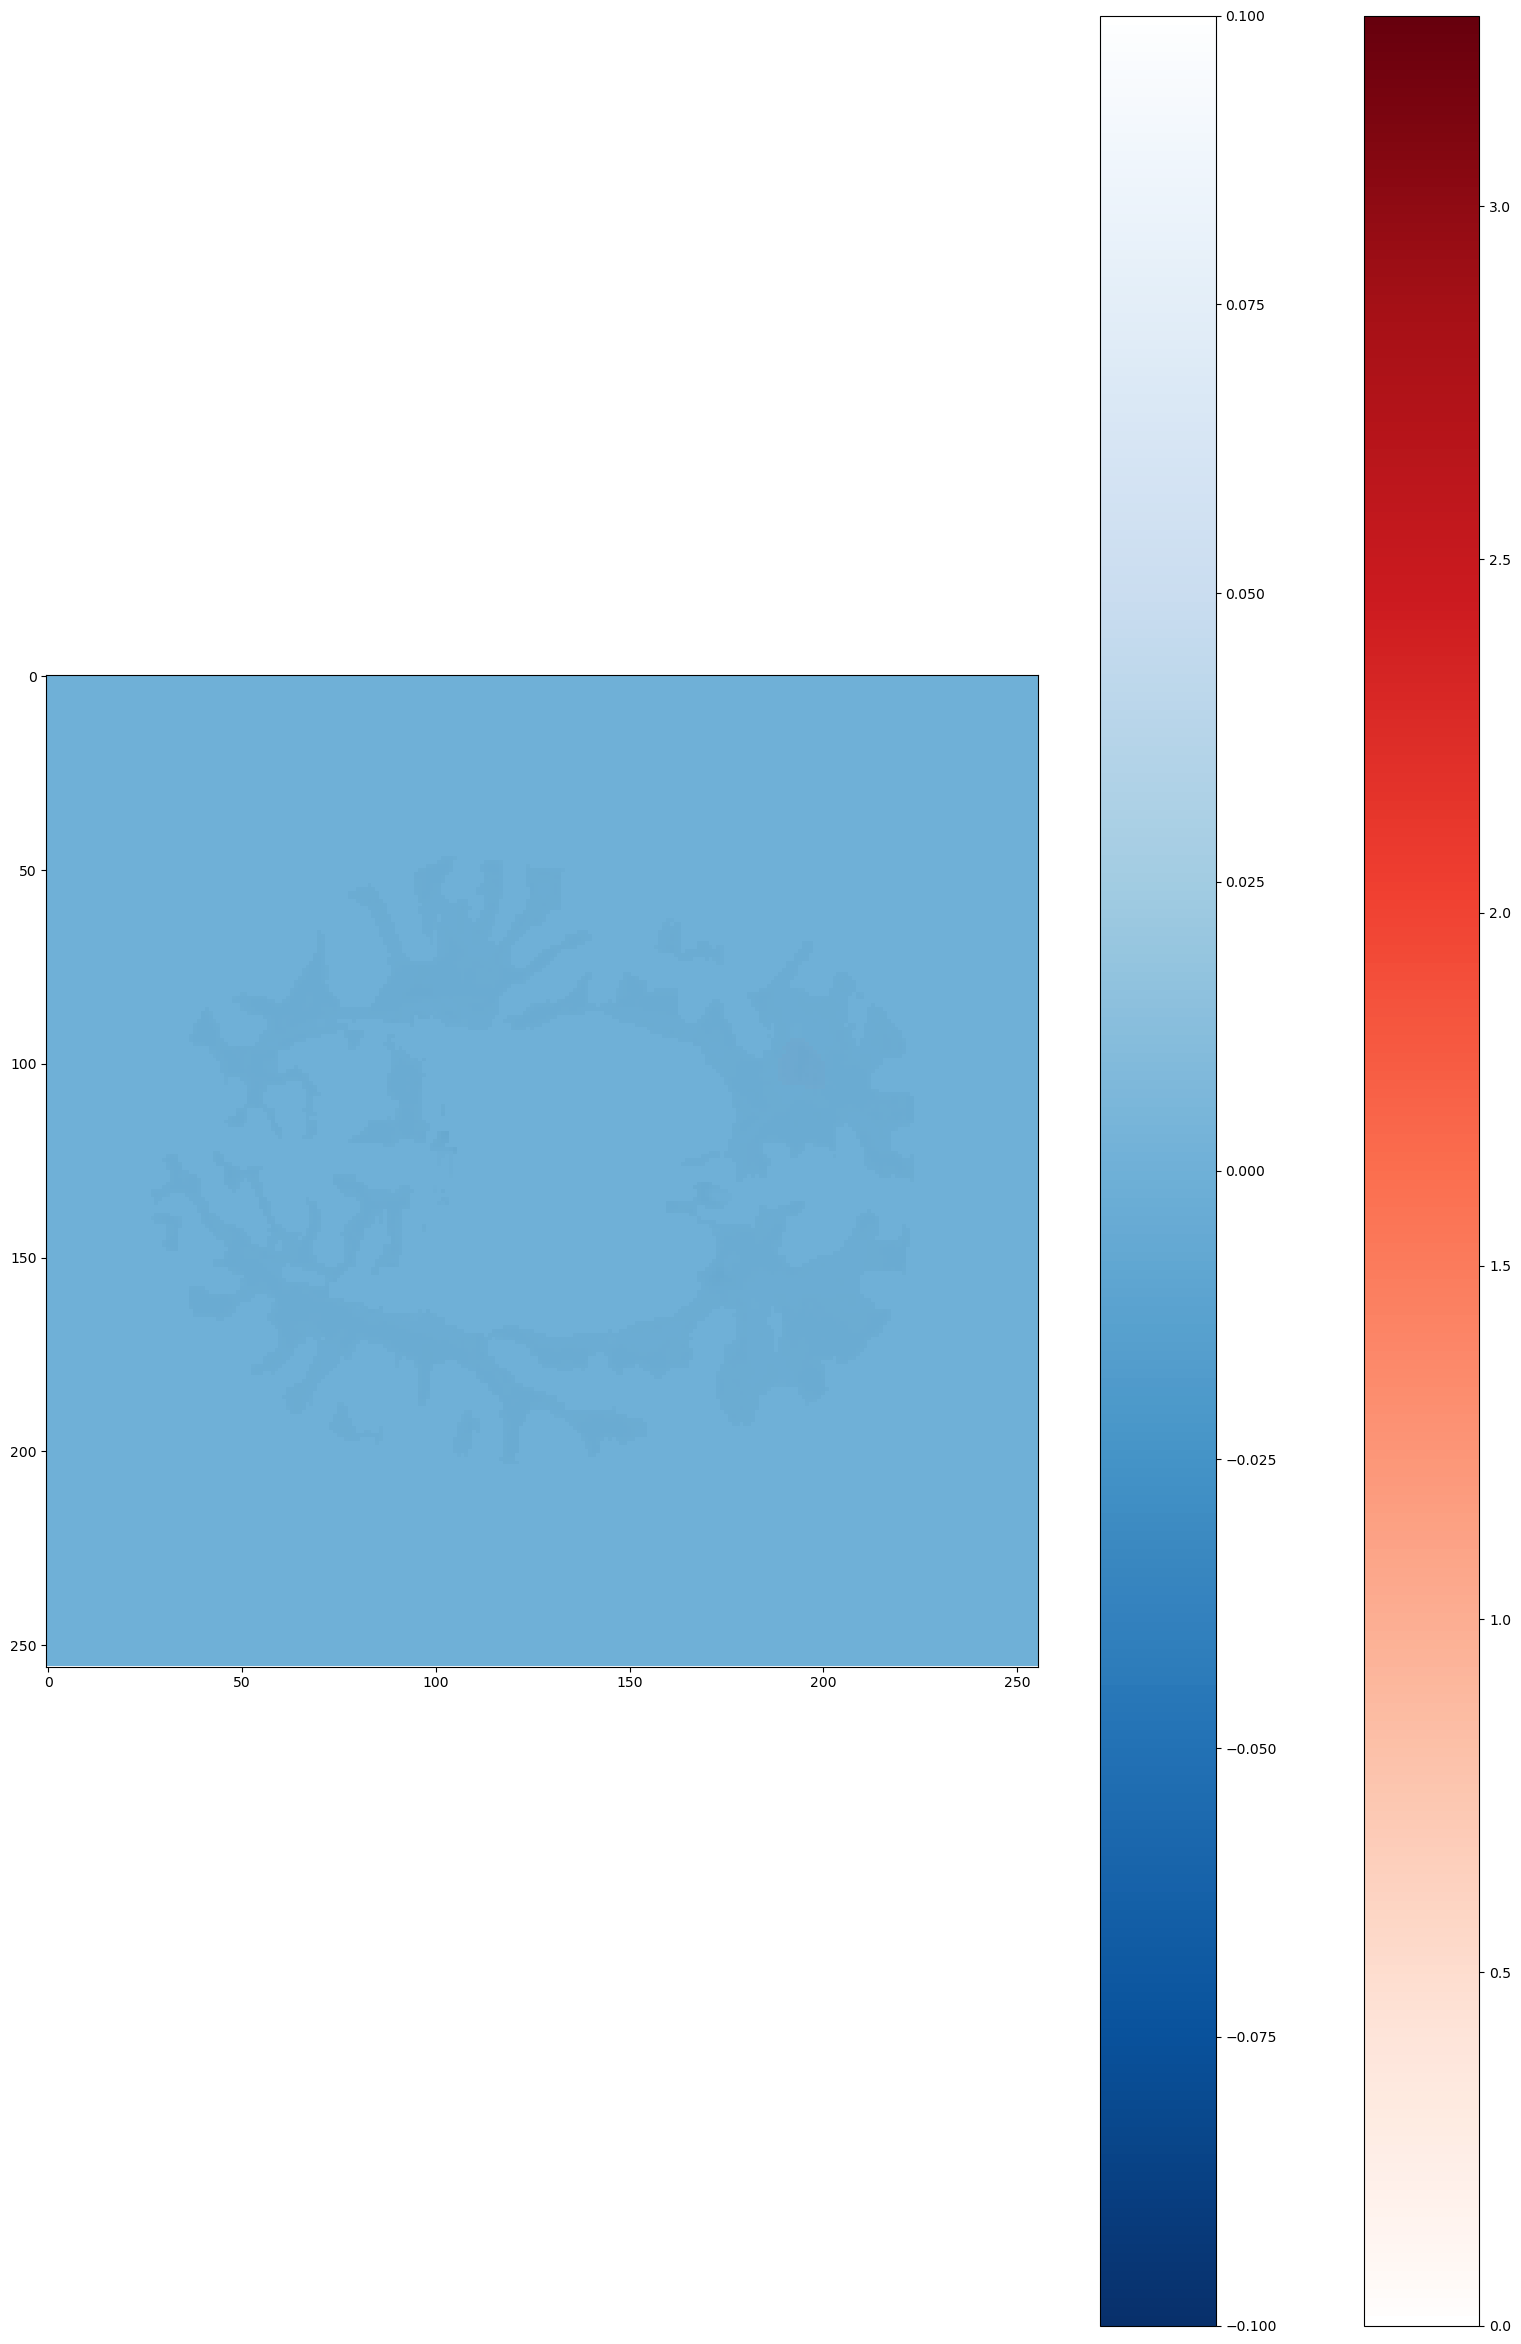

In [97]:
brain_diff(og, pred, threshold=2)

### Try AE

In [20]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 128, 3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(128, 16, 3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.LeakyReLU()
        )
        self.latent = nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024, 512),
            nn.Linear(512, 1024),
            nn.Unflatten(-1, (16, 8, 8))
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.latent(x)
        x = self.decoder(x)
        
        return x

In [23]:
model = AE()

# model = nn.DataParallel(model)
model.cuda()
criterion = nn.MSELoss()
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-07)

num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0
    with tqdm(train, unit="batch", ascii=' >=') as tepoch:
        model.train()
        data_counter = 0
        for data in tepoch:
            for x, y in data:
                optimizer.zero_grad()
                
                x = torch.Tensor(x).cuda()
                y = torch.Tensor(y).cuda()
                
                output = model(x)
                loss = criterion(y, output)
                
                # backward
                loss.backward()
                optimizer.step()

                total_loss += loss.data
                data_counter += 1

        total_loss /= data_counter
            
        tepoch.set_postfix(loss=loss.item())
        val_loss = 0
        model.eval()
        data_counter = 0
        for data in val:
            with torch.no_grad():
                for x, y in data:
                    x = torch.Tensor(x).cuda()
                    y = torch.Tensor(y).cuda()

                    output = model(x)
                    loss = criterion(y, output)

                    val_loss += loss.data
                    data_counter += 1
        
        val_loss /= data_counter
        
        print('epoch [{}/{}], train_loss:{:.4f}, val_loss:{:.4f}'
              .format(epoch+1, num_epochs, total_loss, val_loss))

100%|=============================================================================| 166/166 [03:10<00:00,  1.15s/batch]


epoch [1/100], train_loss:0.0120, val_loss:0.0048


100%|=============================================================================| 166/166 [03:23<00:00,  1.23s/batch]


epoch [2/100], train_loss:0.0048, val_loss:0.0054


100%|=============================================================================| 166/166 [03:26<00:00,  1.24s/batch]


epoch [3/100], train_loss:0.0043, val_loss:0.0058


100%|=============================================================================| 166/166 [03:26<00:00,  1.24s/batch]


epoch [4/100], train_loss:0.0041, val_loss:0.0055


100%|=============================================================================| 166/166 [03:27<00:00,  1.25s/batch]


epoch [5/100], train_loss:0.0040, val_loss:0.0087


100%|=============================================================================| 166/166 [03:28<00:00,  1.25s/batch]


epoch [6/100], train_loss:0.0040, val_loss:0.0043


100%|=============================================================================| 166/166 [03:26<00:00,  1.24s/batch]


epoch [7/100], train_loss:0.0038, val_loss:0.0043


100%|=============================================================================| 166/166 [03:29<00:00,  1.26s/batch]


epoch [8/100], train_loss:0.0038, val_loss:0.0046


100%|=============================================================================| 166/166 [03:31<00:00,  1.27s/batch]


epoch [9/100], train_loss:0.0038, val_loss:0.0042


100%|=============================================================================| 166/166 [03:31<00:00,  1.27s/batch]


epoch [10/100], train_loss:0.0037, val_loss:0.0041


100%|=============================================================================| 166/166 [03:29<00:00,  1.26s/batch]


epoch [11/100], train_loss:0.0037, val_loss:0.0042


100%|=============================================================================| 166/166 [03:30<00:00,  1.27s/batch]


epoch [12/100], train_loss:0.0036, val_loss:0.0042


100%|=============================================================================| 166/166 [03:29<00:00,  1.26s/batch]


epoch [13/100], train_loss:0.0036, val_loss:0.0061


100%|=============================================================================| 166/166 [03:29<00:00,  1.26s/batch]


epoch [14/100], train_loss:0.0036, val_loss:0.0040


100%|=============================================================================| 166/166 [03:30<00:00,  1.27s/batch]


epoch [15/100], train_loss:0.0036, val_loss:0.0041


100%|=============================================================================| 166/166 [03:28<00:00,  1.26s/batch]


epoch [16/100], train_loss:0.0035, val_loss:0.0039


100%|=============================================================================| 166/166 [03:28<00:00,  1.26s/batch]


epoch [17/100], train_loss:0.0035, val_loss:0.0039


100%|=============================================================================| 166/166 [03:30<00:00,  1.27s/batch]


epoch [18/100], train_loss:0.0034, val_loss:0.0039


100%|=============================================================================| 166/166 [03:29<00:00,  1.26s/batch]


epoch [19/100], train_loss:0.0034, val_loss:0.0039


100%|=============================================================================| 166/166 [03:29<00:00,  1.26s/batch]


epoch [20/100], train_loss:0.0034, val_loss:0.0044


100%|=============================================================================| 166/166 [03:29<00:00,  1.26s/batch]


epoch [21/100], train_loss:0.0034, val_loss:0.0042


 14%|===========                                                                   | 24/166 [00:32<03:09,  1.33s/batch]


KeyboardInterrupt: 

Text(0.5, 1.0, 'OG - Refined Seg Pred')

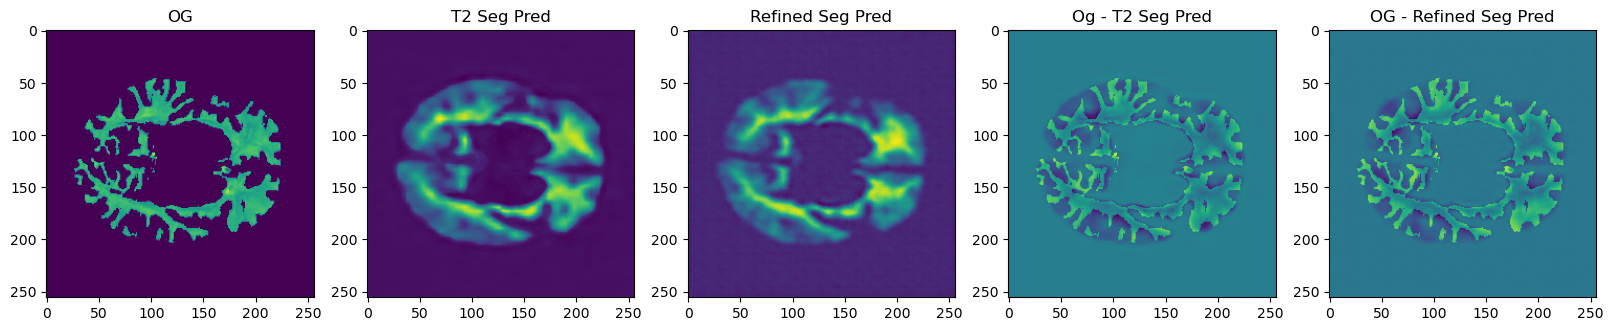

In [24]:
x,y = train[0][1]
x = torch.Tensor(x).cuda()
y = torch.Tensor(y).cuda()
output = model(x)

og = np.reshape(y.detach().cpu().numpy()[-1], (256, 256))
og_pred = np.reshape(x.detach().cpu().numpy()[-1], (256, 256))
pred = np.reshape(output.detach().cpu().numpy()[-1], (256, 256))

fig, ax = plt.subplots(1, 5, figsize=(20,20))

ax[0].imshow(og)
ax[0].set_title("OG")

ax[1].imshow(og_pred)
ax[1].set_title("T2 Seg Pred")

ax[2].imshow(pred)
ax[2].set_title("Refined Seg Pred")

ax[3].imshow(og - og_pred)
ax[3].set_title("Og - T2 Seg Pred")

ax[4].imshow(og - pred)
ax[4].set_title("OG - Refined Seg Pred")